In [337]:
!pip install lazypredict
!pip install xgboost
!pip install lightgbm
!pip install pytest
import pandas as pd
import datetime
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api         as sm
import statsmodels.formula.api as smf
from scipy.interpolate import interp1d
from scipy import stats
import random
from sklearn.model_selection import StratifiedKFold

import lazypredict
from lazypredict.Supervised import LazyRegressor
from lazypredict.Supervised import LazyClassifier
from sklearn import datasets
from sklearn.utils import shuffle


from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import balanced_accuracy_score
from joblib import dump, load



Lectura de la sabana de datos

In [2]:
# read file
path = "data/"
file = "sabana_outer_21_07_2020_v1_DF.csv"
#file = "sabana_outer_v3_DF.csv"
df=pd.read_csv(path + file)
df = df.astype('category')
cols = df.columns

#df.columns[pd.Series(df.columns).str.startswith('medicamento')]
cols

Index(['fecha_consulta', 'sexo_paciente', 'fecha_nacimiento',
       'diagnostico_principal', 'imc', 'fecha2', 'bsa',
       'calidad de vida relacionada en salud', 'dlqi', 'easi',
       ...
       'pasi -> entre 10-15',
       'sindrome metabolico -> presencia de sindrome metabolico complet',
       'terapia biologica -> medicamento que requiere ajuste de dosis p',
       'terapia biologica -> tratamiento activo',
       'terapia sistematica previa -> tratamiento previo con fallo tera',
       'terapia sistemica de primera linea -> tratamiento activo', 'id', 'ano',
       'mes', 'dia'],
      dtype='object', length=260)

Algunas variables son numéricas y otras categóricas

In [3]:
df["fecha_consulta"] = pd.to_datetime(df['fecha_consulta'])
df["fecha_nacimiento"] = pd.to_datetime(df['fecha_nacimiento'])

df["id"] = df["id"].astype('Int64')
df["dia"] = df["dia"].astype('Int64')
df["mes"] = df["mes"].astype('Int64')
df["ano"] = df["ano"].astype('Int64')
df["pasi"] = df["pasi"].astype('float')
df["edad"] = round(df["ano"]- pd.DatetimeIndex(df["fecha_nacimiento"]).year,0)
print(df.shape)
df.sample(5)

(18408, 261)


,fecha_consulta,sexo_paciente,fecha_nacimiento,diagnostico_principal,imc,fecha2,bsa,calidad de vida relacionada en salud,dlqi,easi,...,sindrome metabolico -> presencia de sindrome metabolico complet,terapia biologica -> medicamento que requiere ajuste de dosis p,terapia biologica -> tratamiento activo,terapia sistematica previa -> tratamiento previo con fallo tera,terapia sistemica de primera linea -> tratamiento activo,id,ano,mes,dia,edad
16361,2020-05-12,f,1959-01-05,l400,nan,2020-05-12,0.00,nan,0.00,nan,...,no,no,no,no,no,843514,2020,5,12,61.00
12422,2019-01-09,m,1988-07-09,l400,30.60,2019-01-09,nan,nan,nan,nan,...,NaN,NaN,NaN,NaN,NaN,1452149,2019,1,9,31.00
10627,2019-08-05,m,1964-02-28,l400,27.10,2019-08-05,12.00,nan,17.00,nan,...,no,no,no,no,no,1723043,2019,8,5,55.00
10959,NaT,NaN,NaT,NaN,nan,2018-07-19,nan,nan,0.00,nan,...,NaN,NaN,NaN,NaN,NaN,1649345,2018,7,19,nan
13053,2019-09-30,f,1950-03-22,l400,28.10,2019-09-30,nan,nan,nan,nan,...,NaN,NaN,NaN,NaN,NaN,1359434,2019,9,30,69.00


Definición de valores máximos y mínimos de las variables numéricas.

In [4]:
df_minmax=pd.DataFrame(data={'dlqi': [0, 30],'imc': [10, 35],'bsa': [0, 100],'edad': [0,100],'depresion_total': [0,10],
                               'ansiedad_total': [0,10],'trastorno_sexual_total': [0,10],  'psi_total': [0,10]}, 
                         index = ["min", "max"])
df_minmax

,dlqi,imc,bsa,edad,depresion_total,ansiedad_total,trastorno_sexual_total,psi_total
min,0,10,0,0,0,0,0,0
max,30,35,100,100,10,10,10,10


Normalización y selección de variables para analizar.

In [5]:
ids = df["id"].unique()#los id en el dataset
df.columns = df.columns.str.replace("/", "__")
df.columns = df.columns.str.replace(" ", "_")
df.columns = df.columns.str.replace("+", "_con_")
df.columns = df.columns.str.replace("-", "_")
df.columns = df.columns.str.replace(">", "A_")
df.columns = df.columns.str.replace("<", "_A")
df["ano_dec"] = df["ano"]+(1/12)*df["mes"] + (1/365)*df["dia"]
cols = df.columns# las variables medidas
col_num = ["dlqi", "imc", "bsa", "edad", "depresion_total", "ansiedad_total" , "trastorno_sexual_total", "psi_total"]
col_med = cols[pd.Series(cols).str.startswith('medicamento')]
med_interes = ["adalimumab", "certolizumab","etanercept", "golimumab", "guselkumab",
               "infliximab", "ixekinumab", "secukinumab", "ustekinumab", "mometasona"]
varsX = []
for c in cols:
    if c in col_num:
        temp = df[c].astype('float')
        df[c] = (temp - df_minmax[c]['min'])/(df_minmax[c]['max'] - df_minmax[c]['min'])
        varsX.append(c)
    if c in col_med:
        if any(substring in c for substring in med_interes):
            varsX.append(c)
varsX.append('eritema')
varsX.append('endurecimiento')
varsX.append('descamacion')
varsX.append('pga')

varsX


['imc',
 'bsa',
 'dlqi',
 'depresion_total',
 'ansiedad_total',
 'trastorno_sexual_total',
 'psi_total',
 'medicamento_acido_folico__mometasona',
 'medicamento_acido_salicilico__mometasona',
 'medicamento_adalimumab',
 'medicamento_certolizumab',
 'medicamento_etanercept',
 'medicamento_golimumab',
 'medicamento_guselkumab',
 'medicamento_infliximab',
 'medicamento_ixekinumab',
 'medicamento_mometasona',
 'medicamento_secukinumab',
 'medicamento_ustekinumab',
 'edad',
 'eritema',
 'endurecimiento',
 'descamacion',
 'pga']

version decimal de la fecha.. ano.decimal

In [6]:
varsY = ["pasi"]

In [7]:
#df.interpolate(method='linear', limit_direction='forward', axis=0)


df2 tiene solamente los datos de las columnas seleccionadas

In [8]:
sel = ["id","ano","mes","dia","sexo_paciente"]
for v in varsX:
    sel.append(v)
    print(v)
    print(df[v].unique())
for v in varsY:
    sel.append(v)

df2 = df[sel]


imc
[6.68000000e-01            nan 5.44000000e-01 5.20000000e-01
 4.60000000e-01 5.28000000e-01 6.12000000e-01 6.64000000e-01
 6.24000000e-01 5.68000000e-01 5.92000000e-01 6.16000000e-01
 6.56000000e-01 6.84000000e-01 3.29200000e+00 9.08000000e-01
 9.22000000e-01 1.01200000e+00 9.96000000e-01 1.00400000e+00
 1.04800000e+00 1.02400000e+00 1.02000000e+00 9.88000000e-01
 9.68000000e-01 5.96000000e-01 5.76000000e-01 5.88000000e-01
 6.08000000e-01 6.40000000e-01 6.96000000e-01 5.48000000e-01
 9.00000000e-01 8.92000000e-01 8.80000000e-01 9.32000000e-01
 9.16000000e-01 9.60000000e-01 9.24000000e-01 8.56000000e-01
 7.52000000e-01 8.48000000e-01 7.56000000e-01 1.03600000e+00
 1.01800000e+00 1.04000000e+00 7.60000000e-01 7.28000000e-01
 7.16000000e-01 5.84000000e-01 7.64000000e-01 7.48000000e-01
 7.80000000e-01 7.32000000e-01 7.92000000e-01 7.88000000e-01
 7.34000000e-01 7.72000000e-01 8.04000000e-01 7.76000000e-01
 7.44000000e-01 7.12000000e-01 6.28000000e-01 6.92000000e-01
 6.36000000e-01 6.80

| variable                   | tipo | valores                                                 |
|----------------------------|------|---------------------------------------------------------|
| dlqi                       | num  | numeros                                                 |
| imc                        | num  | numeros                                                 |
| bsa                        | num  | numeros                                                 |
| edad                       | num  | numeros                                                 |
| depresion_total (*)        | num  | numeros                                                 |
| ansiedad_total  (*)        | num  | numeros                                                 |
| trastorno_sexual_total (*) | num  | numeros                                                 |
| psi_total                  | num  | numeros                                                 |
| eritema                    | cat  | 0 1 2 3 4 5                                             |
| endurecimiento             | cat  | 0 1 2 3 4 5                                             |
| descamacion                | cat  | 0 1 2 3 4 5                                             |
| pga                        | cat  | 0 1 2 3 4 5                                             |
| sexo_paciente              | cat  | f m                                                     |
| medicamento_XXXX           | cat  | 0 1                                                     |
| area   XXXXXX              | cat  | 0 '<10%' '10-29%' '30-49%'  '50-69%' '70-89%' '90-100%' |
| sindrome metabolico        | cat  | si no                                                   |
| terapia xxxxx -> yyyy      | cat  | si no                                                   |

- df3_0 tienen los datos interpolados de las columnas seleccionadas en el instante k.
- df3_1 tienen los datos interpolados de las columnas seleccionadas en el instante k-1.
- df4 tiene a df3_0 y df3_1 así como la estimación de cambio de pasi

In [9]:
def llena_datos(df):
    cols = df.columns
    for c in cols:
        print(c)
        if df[c].dtype in ["Int64", "float64"]:
            if c in ["id"]:
                df2[c] = df[c]
            else:
                df2[c] = df[c].interpolate(method='linear', limit_direction='forward', axis=0)
        else:
            df2[c] = df[c].fillna( method ='ffill')
            
    return df2


In [10]:
df2.sort_values(by=["ano","mes","dia"],inplace = True)

df3_0 = df2[df2["id"]==ids[0]].reset_index().fillna( method ='ffill')
# df3_0 = df2[df2["id"]==ids[0]].reset_index().interpolate(method='linear', limit_direction='forward', axis=0)
# df3_0 = llena_datos(df2[df2["id"]==ids[0]])

df3_1 = df3_0.shift(periods=1)

for id in ids[1:]:
    df2_id = df2[df2["id"]==id].reset_index().fillna( method ='ffill')
    # df2_id = df2[df2["id"]==id].reset_index().interpolate(method='linear', limit_direction='forward', axis=0)
    # df_2_id = llena_datos(df2[df2["id"]==id])
    df3_0 = pd.concat([df3_0, df2_id],
                      axis=0, join='outer', ignore_index=False)
    df3_1 = pd.concat([df3_1, df2_id.shift(periods=1)], 
                      axis=0, join='outer', ignore_index=False)

    #df3_0 = df3_0.append(df2_id, ignore_index=True)
    #df3_1 = df3_1.append(df2_id.shift(periods=1), ignore_index=True)
df3_0.drop('index', axis=1, inplace=True)
df3_1.drop('index', axis=1, inplace=True)

for c in cols:
    df3_1.rename(columns={c : c + "_1"}, inplace = True)
df3_1.columns
df3_1.drop('id_1', axis=1, inplace=True)
df3_1.drop('sexo_paciente_1', axis=1, inplace=True)


In [11]:
df3_1.columns

Index(['ano_1', 'mes_1', 'dia_1', 'imc_1', 'bsa_1', 'dlqi_1',
       'depresion_total_1', 'ansiedad_total_1', 'trastorno_sexual_total_1',
       'psi_total_1', 'medicamento_acido_folico__mometasona_1',
       'medicamento_acido_salicilico__mometasona_1',
       'medicamento_adalimumab_1', 'medicamento_certolizumab_1',
       'medicamento_etanercept_1', 'medicamento_golimumab_1',
       'medicamento_guselkumab_1', 'medicamento_infliximab_1',
       'medicamento_ixekinumab_1', 'medicamento_mometasona_1',
       'medicamento_secukinumab_1', 'medicamento_ustekinumab_1', 'edad_1',
       'eritema_1', 'endurecimiento_1', 'descamacion_1', 'pga_1', 'pasi_1'],
      dtype='object')

definir como «psoriasis grave» a efectos de la inclusión en ensayos clínicos la de los
pacientes con BSA &gt; 10 % y PASI &gt; 12.

para otros es útil la
«regla de los 10», definiendo como psoriasis grave la de los pacientes con PASI &gt; 10, o BSA &gt; 10 o
una puntuación &gt; 10 en la escala de calidad de vida Dermatology Life Quality Index (DLQI).

Se define como falta de respuesta o fracaso terapéutico: a) no conseguir–o perder la
respuesta correspondiente a– una disminución del 50 % de la puntuación PASI basal, o bien b)
mantener una puntuación igual o superior a cualquiera de las que constituyen criterio de psoriasis
moderada a grave según se ha definido,

In [12]:
df4 = pd.concat([df3_0, df3_1], axis=1)

df4["fecha_dec"] =   df4["ano"]   + (1/12)*df4["mes"]   + (1/365)*df4["dia"]
df4["fecha_dec_1"] = df4["ano_1"] + (1/12)*df4["mes_1"] + (1/365)*df4["dia_1"]
df4["meses_desde_consulta"] = 12*(df4["fecha_dec"] - df4["fecha_dec_1"]) 

df4["dpasi"] = df4["pasi"] - df4["pasi_1"]
df4["dpasi_mes"] = df4["dpasi"] / df4["meses_desde_consulta"] 
df4["dpasi_porc_mes"] = df4["dpasi"] / (df4["pasi_1"] * df4["meses_desde_consulta"] )
df4["dpasi_porc"] = df4["dpasi"] / (df4["pasi_1"] + 1e-10)

# df4["fracaso"] = np.where( (df4["dpasi_porc"] < 0.5)  | (df4["pasi"] > 7) | (df4["bsa"] > 5) ,1 , 0)
 
df4["fracaso"] = np.where( (df4["dpasi_porc"] > -0.5)  | 
                          (df4["pasi"] > 10) | 
                          (df4["bsa"] > 10) |
                          (df4["dlqi"] > 10) ,1 , 0)
df4.head()

,id,ano,mes,dia,sexo_paciente,imc,bsa,dlqi,depresion_total,ansiedad_total,...,pga_1,pasi_1,fecha_dec,fecha_dec_1,meses_desde_consulta,dpasi,dpasi_mes,dpasi_porc_mes,dpasi_porc,fracaso
0,20946751,2018,12,13,f,0.67,nan,0.10,nan,nan,...,nan,nan,2019.04,nan,nan,nan,nan,nan,nan,0
0,3499725,2013,5,2,NaN,nan,nan,nan,nan,nan,...,nan,nan,2013.42,nan,nan,nan,nan,nan,nan,0
1,3499725,2013,7,29,NaN,nan,nan,nan,nan,nan,...,nan,nan,2013.66,2013.42,2.89,nan,nan,nan,nan,0
2,3499725,2018,7,27,m,0.53,nan,0.03,nan,nan,...,nan,nan,2018.66,2013.66,59.93,nan,nan,nan,nan,0
3,3499725,2018,10,24,m,0.53,nan,0.03,nan,nan,...,nan,0.40,2018.90,2018.66,2.90,0.00,0.00,0.00,0.00,1


In [13]:
df5 = df4.drop('pasi', axis=1).merge(df[['id', 'ano', 'mes', 'dia', 'pasi']], how = 'left',
                on = ['id', 'ano', 'mes', 'dia'])

In [14]:
df5[df5["id"]==3499725][["id","ano","mes","dia","pasi_1","pasi","dpasi"]]

,id,ano,mes,dia,pasi_1,pasi,dpasi
1,3499725,2013,5,2,nan,nan,nan
2,3499725,2013,7,29,nan,nan,nan
3,3499725,2018,7,27,nan,0.40,nan
4,3499725,2018,10,24,0.40,nan,0.00
5,3499725,2019,5,24,0.40,0.00,-0.40
6,3499725,2019,6,19,0.00,nan,0.00
7,3499725,2019,7,9,0.00,nan,0.00
8,3499725,2019,11,14,0.00,nan,0.00
9,3499725,2019,12,9,0.00,0.20,0.20
10,3499725,2020,1,20,0.20,nan,0.00


In [15]:
df4[df4["id"]==3499725][["id","ano","mes","dia","pasi_1","pasi","dpasi_mes","dlqi","bsa","psi_total","imc"]]

,id,ano,mes,dia,pasi_1,pasi,dpasi_mes,dlqi,bsa,psi_total,imc
0,3499725,2013,5,2,nan,nan,nan,nan,nan,nan,nan
1,3499725,2013,7,29,nan,nan,nan,nan,nan,nan,nan
2,3499725,2018,7,27,nan,0.40,nan,0.03,nan,nan,0.53
3,3499725,2018,10,24,0.40,0.40,0.00,0.03,nan,nan,0.53
4,3499725,2019,5,24,0.40,0.00,-0.06,0.03,0.00,0.00,0.46
5,3499725,2019,6,19,0.00,0.00,0.00,0.03,0.00,0.00,0.53
6,3499725,2019,7,9,0.00,0.00,0.00,0.03,0.00,0.00,0.46
7,3499725,2019,11,14,0.00,0.00,0.00,0.03,0.00,0.00,0.46
8,3499725,2019,12,9,0.00,0.20,0.24,0.03,0.01,0.00,0.52
9,3499725,2020,1,20,0.20,0.20,0.00,0.03,0.01,0.00,0.54


In [16]:
for c in df5.columns:
    print(c)

id
ano
mes
dia
sexo_paciente
imc
bsa
dlqi
depresion_total
ansiedad_total
trastorno_sexual_total
psi_total
medicamento_acido_folico__mometasona
medicamento_acido_salicilico__mometasona
medicamento_adalimumab
medicamento_certolizumab
medicamento_etanercept
medicamento_golimumab
medicamento_guselkumab
medicamento_infliximab
medicamento_ixekinumab
medicamento_mometasona
medicamento_secukinumab
medicamento_ustekinumab
edad
eritema
endurecimiento
descamacion
pga
ano_1
mes_1
dia_1
imc_1
bsa_1
dlqi_1
depresion_total_1
ansiedad_total_1
trastorno_sexual_total_1
psi_total_1
medicamento_acido_folico__mometasona_1
medicamento_acido_salicilico__mometasona_1
medicamento_adalimumab_1
medicamento_certolizumab_1
medicamento_etanercept_1
medicamento_golimumab_1
medicamento_guselkumab_1
medicamento_infliximab_1
medicamento_ixekinumab_1
medicamento_mometasona_1
medicamento_secukinumab_1
medicamento_ustekinumab_1
edad_1
eritema_1
endurecimiento_1
descamacion_1
pga_1
pasi_1
fecha_dec
fecha_dec_1
meses_desde_

In [17]:
df5

,id,ano,mes,dia,sexo_paciente,imc,bsa,dlqi,depresion_total,ansiedad_total,...,pasi_1,fecha_dec,fecha_dec_1,meses_desde_consulta,dpasi,dpasi_mes,dpasi_porc_mes,dpasi_porc,fracaso,pasi
0,20946751,2018,12,13,f,0.67,nan,0.10,nan,nan,...,nan,2019.04,nan,nan,nan,nan,nan,nan,0,0.00
1,3499725,2013,5,2,NaN,nan,nan,nan,nan,nan,...,nan,2013.42,nan,nan,nan,nan,nan,nan,0,nan
2,3499725,2013,7,29,NaN,nan,nan,nan,nan,nan,...,nan,2013.66,2013.42,2.89,nan,nan,nan,nan,0,nan
3,3499725,2018,7,27,m,0.53,nan,0.03,nan,nan,...,nan,2018.66,2013.66,59.93,nan,nan,nan,nan,0,0.40
4,3499725,2018,10,24,m,0.53,nan,0.03,nan,nan,...,0.40,2018.90,2018.66,2.90,0.00,0.00,0.00,0.00,1,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18403,501389,2020,2,28,f,0.58,nan,0.30,0.00,0.00,...,2.70,2020.24,2020.11,1.66,0.00,0.00,0.00,0.00,1,nan
18404,501053,2019,3,4,f,nan,nan,0.03,nan,nan,...,nan,2019.26,nan,nan,nan,nan,nan,nan,0,0.00
18405,501053,2019,11,14,f,0.45,nan,0.00,nan,nan,...,0.00,2019.96,2019.26,8.33,0.00,0.00,nan,0.00,1,0.00
18406,501053,2020,2,12,f,0.45,nan,0.00,nan,nan,...,0.00,2020.20,2019.96,2.93,0.00,0.00,nan,0.00,1,nan


In [18]:
#plt.figure(figsize=(20,20))
#sns.clustermap(df5.dropna().corr())

In [19]:
df4.dropna().shape

(3118, 66)

In [20]:
df5.shape

(18408, 66)

In [21]:
df4[df4["id"]==3499725][["id","ano","mes","dia","pasi_1","pasi","dpasi"]]

,id,ano,mes,dia,pasi_1,pasi,dpasi
0,3499725,2013,5,2,nan,nan,nan
1,3499725,2013,7,29,nan,nan,nan
2,3499725,2018,7,27,nan,0.40,nan
3,3499725,2018,10,24,0.40,0.40,0.00
4,3499725,2019,5,24,0.40,0.00,-0.40
5,3499725,2019,6,19,0.00,0.00,0.00
6,3499725,2019,7,9,0.00,0.00,0.00
7,3499725,2019,11,14,0.00,0.00,0.00
8,3499725,2019,12,9,0.00,0.20,0.20
9,3499725,2020,1,20,0.20,0.20,0.00


In [22]:
df5[df5["id"]==3499725][["id","ano","mes","dia","pasi_1","pasi","dpasi"]]

,id,ano,mes,dia,pasi_1,pasi,dpasi
1,3499725,2013,5,2,nan,nan,nan
2,3499725,2013,7,29,nan,nan,nan
3,3499725,2018,7,27,nan,0.40,nan
4,3499725,2018,10,24,0.40,nan,0.00
5,3499725,2019,5,24,0.40,0.00,-0.40
6,3499725,2019,6,19,0.00,nan,0.00
7,3499725,2019,7,9,0.00,nan,0.00
8,3499725,2019,11,14,0.00,nan,0.00
9,3499725,2019,12,9,0.00,0.20,0.20
10,3499725,2020,1,20,0.20,nan,0.00


In [23]:
df2[df2["id"]==3499725][["id","ano","mes","dia","pasi"]]

,id,ano,mes,dia,pasi
14,3499725,2013,5,2,nan
13,3499725,2013,7,29,nan
12,3499725,2018,7,27,0.40
11,3499725,2018,10,24,nan
10,3499725,2019,5,24,0.00
9,3499725,2019,6,19,nan
8,3499725,2019,7,9,nan
7,3499725,2019,11,14,nan
6,3499725,2019,12,9,0.20
5,3499725,2020,1,20,nan


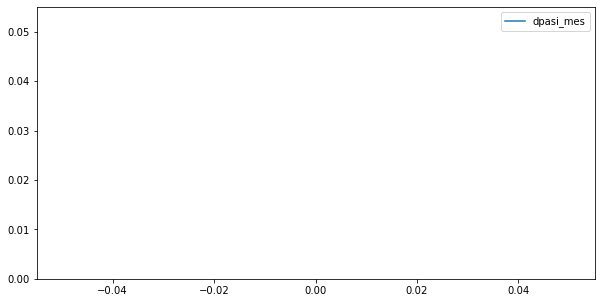

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(10,5))
sns.kdeplot(df5["dpasi_mes"], shade=True,ax = ax);

In [25]:
df5

,id,ano,mes,dia,sexo_paciente,imc,bsa,dlqi,depresion_total,ansiedad_total,...,pasi_1,fecha_dec,fecha_dec_1,meses_desde_consulta,dpasi,dpasi_mes,dpasi_porc_mes,dpasi_porc,fracaso,pasi
0,20946751,2018,12,13,f,0.67,nan,0.10,nan,nan,...,nan,2019.04,nan,nan,nan,nan,nan,nan,0,0.00
1,3499725,2013,5,2,NaN,nan,nan,nan,nan,nan,...,nan,2013.42,nan,nan,nan,nan,nan,nan,0,nan
2,3499725,2013,7,29,NaN,nan,nan,nan,nan,nan,...,nan,2013.66,2013.42,2.89,nan,nan,nan,nan,0,nan
3,3499725,2018,7,27,m,0.53,nan,0.03,nan,nan,...,nan,2018.66,2013.66,59.93,nan,nan,nan,nan,0,0.40
4,3499725,2018,10,24,m,0.53,nan,0.03,nan,nan,...,0.40,2018.90,2018.66,2.90,0.00,0.00,0.00,0.00,1,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18403,501389,2020,2,28,f,0.58,nan,0.30,0.00,0.00,...,2.70,2020.24,2020.11,1.66,0.00,0.00,0.00,0.00,1,nan
18404,501053,2019,3,4,f,nan,nan,0.03,nan,nan,...,nan,2019.26,nan,nan,nan,nan,nan,nan,0,0.00
18405,501053,2019,11,14,f,0.45,nan,0.00,nan,nan,...,0.00,2019.96,2019.26,8.33,0.00,0.00,nan,0.00,1,0.00
18406,501053,2020,2,12,f,0.45,nan,0.00,nan,nan,...,0.00,2020.20,2019.96,2.93,0.00,0.00,nan,0.00,1,nan


In [26]:
df4["dpasi_mes"].describe()

count   11919.00
mean       -0.51
std         9.89
min      -620.50
25%         0.00
50%         0.00
75%         0.00
max       149.04
Name: dpasi_mes, dtype: float64

In [27]:
dpasi_f0 = ('dpasi_mes ~ pasi_1 + imc_1 + bsa_1 + dlqi_1 + pga_1 + edad_1 + '
            'depresion_total_1 + ansiedad_total_1 + trastorno_sexual_total_1 + psi_total_1 + '
            'eritema_1 + endurecimiento_1 + descamacion_1 + '
            'medicamento_adalimumab + medicamento_certolizumab + medicamento_etanercept + '
            'medicamento_golimumab + medicamento_guselkumab + medicamento_infliximab + '
            'medicamento_ixekinumab + medicamento_secukinumab  + medicamento_ustekinumab + '
            'medicamento_adalimumab*pasi_1 + medicamento_certolizumab*pasi_1 + medicamento_etanercept*pasi_1 + '
            'medicamento_golimumab*pasi_1 + medicamento_guselkumab*pasi_1 + medicamento_infliximab*pasi_1 + '
            'medicamento_ixekinumab*pasi_1 + medicamento_secukinumab*pasi_1  + medicamento_ustekinumab*pasi_1' 
           )
model_f0 = smf.ols(formula = dpasi_f0, data = df4.dropna()).fit()
model_f0.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              dpasi_mes   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     2.220
Date:                Thu, 30 Jul 2020   Prob (F-statistic):           5.10e-06
Time:                        17:25:42   Log-Likelihood:                -12626.
No. Observations:                3118   AIC:                         2.535e+04
Df Residuals:                    3071   BIC:                         2.563e+04
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                                  0.8747      1.428      0.613      0.540      -1.925       3.674
pga_1[T.1.0]                              -0.9080      1.511     -0.601      0.548      -3.871       2.055
pga_1[T.2.0]                              -2.7503      1.769     -1.555      0.120      -6.218       0.717
pga_1[T.3.0]                               0.5348      2.077      0.258      0.797      -3.538       4.607
pga_1[T.4.0]                              -2.7301      2.623     -1.041      0.298      -7.874       2.413
pga_1[T.5.0]                              -1.5293      6.501     -0.235      0.814     -14.276      11.218
eritema_1[T.1.0]                          -0.8669      1.113     -0.779      0.436      -3.050       1.316
eritema_1[T.2.0]                          -0.3179      1.283     -0.248      0.804      -2.834       2.198
eritema_1[T.3.0]                           0.3789      1.492      0.254      0.800      -2.547       3.305
eritema_1[T.4.0]                           1.1388      1.910      0.596      0.551      -2.605       4.883
eritema_1[T.5.0]                          -0.1395      4.759     -0.029      0.977      -9.471       9.192
endurecimiento_1[T.1.0]                    2.8021      1.016      2.758      0.006       0.810       4.794
endurecimiento_1[T.2.0]                    4.6545      1.290      3.608      0.000       2.125       7.184
endurecimiento_1[T.3.0]                    4.9893      1.590      3.137      0.002       1.871       8.108
endurecimiento_1[T.4.0]                    4.0408      2.010      2.011      0.044       0.100       7.981
endurecimiento_1[T.5.0]                    3.5169      4.800      0.733      0.464      -5.894      12.928
descamacion_1[T.1.0]                      -0.5521      1.209     -0.457      0.648      -2.923       1.819
descamacion_1[T.2.0]                      -1.4614      1.441     -1.014      0.310      -4.286       1.363
descamacion_1[T.3.0]                      -3.7427      1.685     -2.222      0.026      -7.046      -0.440
descamacion_1[T.4.0]                      -1.7019      2.219     -0.767      0.443      -6.052       2.649
descamacion_1[T.5.0]                       3.1281      5.730      0.546      0.585      -8.108      14.364
medicamento_adalimumab[T.1.0]             -1.0846      1.140     -0.951      0.341      -3.320       1.151
medicamento_certolizumab[T.1.0]            0.9112      6.770      0.135      0.893     -12.364      14.186
medicamento_etanercept[T.1.0]             -0.2119      1.589     -0.133      0.894      -3.327       2.903
medicamento_golimumab[T.1.0]               0.3704      8.061      0.046      0.963     -15.435      16.176
medicamento_guselkumab[T.1.0]            -11.7691      4.405     -2.672      0.008     

In [28]:

dpasi_f1 = ('dpasi_mes ~ pasi_1 + imc_1 + bsa_1 + dlqi_1 + pga_1 + edad_1 + '
            'depresion_total_1 + ansiedad_total_1 + trastorno_sexual_total_1 + psi_total_1 + '
            'eritema_1 + endurecimiento_1 + descamacion_1 + '
            'medicamento_adalimumab + medicamento_certolizumab + medicamento_etanercept + '
            'medicamento_golimumab + medicamento_guselkumab + medicamento_infliximab + '
            'medicamento_ixekinumab + medicamento_secukinumab  + medicamento_ustekinumab + '
            'medicamento_adalimumab*pasi_1 + medicamento_certolizumab*pasi_1 + medicamento_etanercept*pasi_1 + '
            'medicamento_golimumab*pasi_1 + medicamento_guselkumab*pasi_1 + medicamento_infliximab*pasi_1 + '
            'medicamento_ixekinumab*pasi_1 + medicamento_secukinumab*pasi_1  + medicamento_ustekinumab*pasi_1' 
           )
model_f1 = smf.ols(formula = dpasi_f1, data = df5.dropna()).fit()
model_f1.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              dpasi_mes   R-squared:                       0.143
Model:                            OLS   Adj. R-squared:                  0.084
Method:                 Least Squares   F-statistic:                     2.430
Date:                Thu, 30 Jul 2020   Prob (F-statistic):           1.27e-06
Time:                        17:25:42   Log-Likelihood:                -3328.8
No. Observations:                 704   AIC:                             6750.
Df Residuals:                     658   BIC:                             6959.
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                                  2.1507      5.776      0.372      0.710      -9.192      13.493
pga_1[T.1.0]                             -10.4938      8.309     -1.263      0.207     -26.809       5.822
pga_1[T.2.0]                             -27.1795     10.596     -2.565      0.011     -47.985      -6.374
pga_1[T.3.0]                             -16.2335     13.326     -1.218      0.224     -42.400       9.933
pga_1[T.4.0]                             -27.6154     18.137     -1.523      0.128     -63.230       7.999
pga_1[T.5.0]                              -7.8430     24.157     -0.325      0.746     -55.277      39.591
eritema_1[T.1.0]                          -1.2589      5.562     -0.226      0.821     -12.181       9.663
eritema_1[T.2.0]                           3.5961      6.399      0.562      0.574      -8.969      16.161
eritema_1[T.3.0]                           7.4622      7.549      0.989      0.323      -7.360      22.285
eritema_1[T.4.0]                          12.6732      9.742      1.301      0.194      -6.456      31.802
eritema_1[T.5.0]                           9.8461     15.911      0.619      0.536     -21.397      41.089
endurecimiento_1[T.1.0]                   13.2022      4.371      3.020      0.003       4.620      21.785
endurecimiento_1[T.2.0]                   26.2791      6.086      4.318      0.000      14.329      38.229
endurecimiento_1[T.3.0]                   26.8425      7.595      3.534      0.000      11.929      41.756
endurecimiento_1[T.4.0]                   23.9681     10.459      2.292      0.022       3.431      44.506
endurecimiento_1[T.5.0]                   25.2961     19.291      1.311      0.190     -12.583      63.175
descamacion_1[T.1.0]                       3.4439      5.686      0.606      0.545      -7.720      14.608
descamacion_1[T.2.0]                       2.1648      6.987      0.310      0.757     -11.554      15.884
descamacion_1[T.3.0]                     -11.7261      8.248     -1.422      0.156     -27.921       4.469
descamacion_1[T.4.0]                      -0.4068     11.119     -0.037      0.971     -22.240      21.427
descamacion_1[T.5.0]                      -1.1622     23.979     -0.048      0.961     -48.247      45.923
medicamento_adalimumab[T.1.0]             -4.1239      4.666     -0.884      0.377     -13.286       5.038
medicamento_certolizumab[T.1.0]           -5.1490     29.481     -0.175      0.861     -63.038      52.740
medicamento_etanercept[T.1.0]              1.4524      6.488      0.224      0.823     -11.287      14.192
medicamento_golimumab[T.1.0]              -3.1864     21.459     -0.148      0.882     -45.323      38.950
medicamento_guselkumab[T.1.0]            -81.1135     37.450     -2.166      0.031    -

In [29]:

dpasi_f2 = ('dpasi_mes ~ pasi_1 + imc_1 + bsa_1 + dlqi_1 + pga_1 + edad_1 + '
            'depresion_total_1 + ansiedad_total_1 + trastorno_sexual_total_1 + psi_total_1 + '
            'eritema_1 + endurecimiento_1 + descamacion_1 + '
            'medicamento_adalimumab + medicamento_certolizumab + medicamento_etanercept + '
            'medicamento_golimumab + medicamento_guselkumab + medicamento_infliximab + '
            'medicamento_ixekinumab + medicamento_secukinumab  + medicamento_ustekinumab'
            )
model_f2 = smf.ols(formula = dpasi_f2, data = df5.dropna()).fit()
model_f2.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              dpasi_mes   R-squared:                       0.137
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     2.858
Date:                Thu, 30 Jul 2020   Prob (F-statistic):           8.44e-08
Time:                        17:25:43   Log-Likelihood:                -3331.1
No. Observations:                 704   AIC:                             6738.
Df Residuals:                     666   BIC:                             6911.
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                           1.0427      5.628      0.185      0.853     -10.008      12.093
pga_1[T.1.0]                      -10.7676      8.046     -1.338      0.181     -26.566       5.031
pga_1[T.2.0]                      -27.7324     10.383     -2.671      0.008     -48.119      -7.346
pga_1[T.3.0]                      -16.9762     13.119     -1.294      0.196     -42.735       8.782
pga_1[T.4.0]                      -29.3304     17.863     -1.642      0.101     -64.406       5.745
pga_1[T.5.0]                       -9.1916     23.340     -0.394      0.694     -55.020      36.636
eritema_1[T.1.0]                   -1.3929      5.481     -0.254      0.799     -12.154       9.369
eritema_1[T.2.0]                    3.5087      6.301      0.557      0.578      -8.864      15.881
eritema_1[T.3.0]                    7.1321      7.458      0.956      0.339      -7.511      21.776
eritema_1[T.4.0]                   13.9915      9.634      1.452      0.147      -4.926      32.909
eritema_1[T.5.0]                   12.7771     15.202      0.841      0.401     -17.072      42.626
endurecimiento_1[T.1.0]            13.3932      4.328      3.095      0.002       4.896      21.891
endurecimiento_1[T.2.0]            26.5927      6.057      4.390      0.000      14.700      38.486
endurecimiento_1[T.3.0]            26.4478      7.545      3.505      0.000      11.633      41.263
endurecimiento_1[T.4.0]            24.0768     10.389      2.318      0.021       3.678      44.476
endurecimiento_1[T.5.0]            28.4544     18.951      1.501      0.134      -8.757      65.665
descamacion_1[T.1.0]                3.8832      5.588      0.695      0.487      -7.088      14.854
descamacion_1[T.2.0]                2.5159      6.874      0.366      0.714     -10.982      16.014
descamacion_1[T.3.0]              -10.5652      8.138     -1.298      0.195     -26.544       5.414
descamacion_1[T.4.0]                1.1335     11.002      0.103      0.918     -20.469      22.736
descamacion_1[T.5.0]               -4.1973     23.572     -0.178      0.859     -50.481      42.087
medicamento_adalimumab[T.1.0]      -3.3374      3.867     -0.863      0.388     -10.930       4.256
medicamento_certolizumab[T.1.0]   -11.1437     16.796     -0.663      0.507     -44.124      21.837
medicamento_etanercept[T.1.0]       1.7022      4.943      0.344      0.731      -8.004      11.409
medicamento_golimumab[T.1.0]       -7.9000     16.551     -0.477      0.633     -40.398      24.598
medicamento_guselkumab[T.1.0]     -33.8587     16.513     -2.050      0.041     -66.282      -1.436
medicamento_infliximab[T.1.0]      -0.8754     28.480     -0.031      0.975     -56.797      55.046
medicamento_ixekinumab[T.1.0]       3.9872      6.082      0.656      0.512      -7

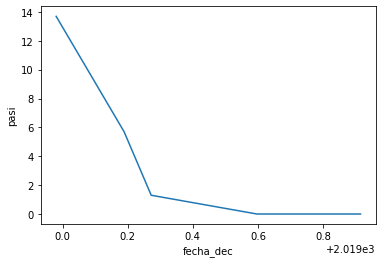

In [30]:
sns.lineplot(x = "fecha_dec",
             y = "pasi",
             data = df5[df5["id"]==ids[2]])

In [31]:
df5

,id,ano,mes,dia,sexo_paciente,imc,bsa,dlqi,depresion_total,ansiedad_total,...,pasi_1,fecha_dec,fecha_dec_1,meses_desde_consulta,dpasi,dpasi_mes,dpasi_porc_mes,dpasi_porc,fracaso,pasi
0,20946751,2018,12,13,f,0.67,nan,0.10,nan,nan,...,nan,2019.04,nan,nan,nan,nan,nan,nan,0,0.00
1,3499725,2013,5,2,NaN,nan,nan,nan,nan,nan,...,nan,2013.42,nan,nan,nan,nan,nan,nan,0,nan
2,3499725,2013,7,29,NaN,nan,nan,nan,nan,nan,...,nan,2013.66,2013.42,2.89,nan,nan,nan,nan,0,nan
3,3499725,2018,7,27,m,0.53,nan,0.03,nan,nan,...,nan,2018.66,2013.66,59.93,nan,nan,nan,nan,0,0.40
4,3499725,2018,10,24,m,0.53,nan,0.03,nan,nan,...,0.40,2018.90,2018.66,2.90,0.00,0.00,0.00,0.00,1,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18403,501389,2020,2,28,f,0.58,nan,0.30,0.00,0.00,...,2.70,2020.24,2020.11,1.66,0.00,0.00,0.00,0.00,1,nan
18404,501053,2019,3,4,f,nan,nan,0.03,nan,nan,...,nan,2019.26,nan,nan,nan,nan,nan,nan,0,0.00
18405,501053,2019,11,14,f,0.45,nan,0.00,nan,nan,...,0.00,2019.96,2019.26,8.33,0.00,0.00,nan,0.00,1,0.00
18406,501053,2020,2,12,f,0.45,nan,0.00,nan,nan,...,0.00,2020.20,2019.96,2.93,0.00,0.00,nan,0.00,1,nan


En este punto, df6 tiene la información filtrada

In [32]:
df6 = df5.dropna()
df6

,id,ano,mes,dia,sexo_paciente,imc,bsa,dlqi,depresion_total,ansiedad_total,...,pasi_1,fecha_dec,fecha_dec_1,meses_desde_consulta,dpasi,dpasi_mes,dpasi_porc_mes,dpasi_porc,fracaso,pasi
9,3499725,2019,12,9,m,0.52,0.01,0.03,0.00,0.00,...,0.00,2020.02,2019.96,0.84,0.20,0.24,inf,2000000000.00,1,0.20
27,3499636,2019,3,8,m,0.59,0.06,0.00,0.00,0.00,...,5.70,2019.27,2019.19,1.00,-4.40,-4.40,-0.77,-0.77,0,1.30
29,3499636,2019,7,5,m,0.57,0.00,0.00,0.00,0.00,...,1.30,2019.60,2019.44,1.90,-1.30,-0.68,-0.53,-1.00,0,0.00
92,3493240,2019,9,18,f,0.93,0.07,0.03,0.00,0.00,...,7.60,2019.80,2019.61,2.26,-4.00,-1.77,-0.23,-0.53,0,3.60
96,3493240,2019,12,18,f,0.89,0.16,0.07,0.00,0.00,...,3.60,2020.05,2020.00,0.64,3.30,5.17,1.44,0.92,1,6.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18303,522458,2020,3,9,m,0.80,0.04,0.57,0.00,0.00,...,2.20,2020.27,2020.09,2.20,1.80,0.82,0.37,0.82,1,4.00
18339,513721,2019,7,12,m,1.08,0.02,0.03,0.00,0.00,...,2.00,2019.62,2019.36,3.10,-0.50,-0.16,-0.08,-0.25,1,1.50
18341,513721,2019,12,4,m,0.96,0.01,0.00,0.00,0.00,...,1.50,2020.01,2019.89,1.44,0.00,0.00,0.00,0.00,1,1.50
18343,513721,2020,3,4,m,0.96,0.00,0.00,0.00,0.00,...,1.50,2020.26,2020.11,1.80,-0.30,-0.17,-0.11,-0.20,1,1.20


In [33]:
df6

,id,ano,mes,dia,sexo_paciente,imc,bsa,dlqi,depresion_total,ansiedad_total,...,pasi_1,fecha_dec,fecha_dec_1,meses_desde_consulta,dpasi,dpasi_mes,dpasi_porc_mes,dpasi_porc,fracaso,pasi
9,3499725,2019,12,9,m,0.52,0.01,0.03,0.00,0.00,...,0.00,2020.02,2019.96,0.84,0.20,0.24,inf,2000000000.00,1,0.20
27,3499636,2019,3,8,m,0.59,0.06,0.00,0.00,0.00,...,5.70,2019.27,2019.19,1.00,-4.40,-4.40,-0.77,-0.77,0,1.30
29,3499636,2019,7,5,m,0.57,0.00,0.00,0.00,0.00,...,1.30,2019.60,2019.44,1.90,-1.30,-0.68,-0.53,-1.00,0,0.00
92,3493240,2019,9,18,f,0.93,0.07,0.03,0.00,0.00,...,7.60,2019.80,2019.61,2.26,-4.00,-1.77,-0.23,-0.53,0,3.60
96,3493240,2019,12,18,f,0.89,0.16,0.07,0.00,0.00,...,3.60,2020.05,2020.00,0.64,3.30,5.17,1.44,0.92,1,6.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18303,522458,2020,3,9,m,0.80,0.04,0.57,0.00,0.00,...,2.20,2020.27,2020.09,2.20,1.80,0.82,0.37,0.82,1,4.00
18339,513721,2019,7,12,m,1.08,0.02,0.03,0.00,0.00,...,2.00,2019.62,2019.36,3.10,-0.50,-0.16,-0.08,-0.25,1,1.50
18341,513721,2019,12,4,m,0.96,0.01,0.00,0.00,0.00,...,1.50,2020.01,2019.89,1.44,0.00,0.00,0.00,0.00,1,1.50
18343,513721,2020,3,4,m,0.96,0.00,0.00,0.00,0.00,...,1.50,2020.26,2020.11,1.80,-0.30,-0.17,-0.11,-0.20,1,1.20


In [34]:

dpasi_f3 = ('dpasi ~ pasi_1 + np.log(imc_1+1e-10) + np.sqrt(bsa_1+1e-10) + np.sqrt(dlqi_1+1e-10) + edad_1 + '
            'np.log(depresion_total_1+1e-10) + np.log(ansiedad_total_1+1e-10) + np.log(psi_total_1+1e-10) + '
            #'eritema_1 + endurecimiento_1 + descamacion_1 + '
            'pga_1 + '
            'medicamento_adalimumab + medicamento_certolizumab + medicamento_etanercept + '
            'medicamento_golimumab + medicamento_guselkumab + medicamento_infliximab + '
            'medicamento_ixekinumab + medicamento_secukinumab  + medicamento_ustekinumab + '
            'medicamento_adalimumab*np.sqrt(pasi_1) + medicamento_certolizumab*np.sqrt(pasi_1) + medicamento_etanercept*np.sqrt(pasi_1) + '
            'medicamento_golimumab*np.sqrt(pasi_1) + medicamento_guselkumab*np.sqrt(pasi_1) + medicamento_infliximab*np.sqrt(pasi_1) + '
            'medicamento_ixekinumab*np.sqrt(pasi_1) + medicamento_secukinumab*np.sqrt(pasi_1)  + medicamento_ustekinumab*np.sqrt(pasi_1)' 
            )
model_f3 = smf.ols(formula = dpasi_f3, data = df6).fit()
model_f3.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  dpasi   R-squared:                       0.516
Model:                            OLS   Adj. R-squared:                  0.494
Method:                 Least Squares   F-statistic:                     23.10
Date:                Thu, 30 Jul 2020   Prob (F-statistic):           1.70e-85
Time:                        17:25:43   Log-Likelihood:                -2010.7
No. Observations:                 704   AIC:                             4085.
Df Residuals:                     672   BIC:                             4231.
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
===================================================================================================================
                                                      coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
Intercept                                           0.8386      3.189      0.263      0.793      -5.423       7.100
pga_1[T.1.0]                                       -0.7682      0.623     -1.234      0.218      -1.991       0.455
pga_1[T.2.0]                                       -0.4729      0.753     -0.628      0.530      -1.951       1.005
pga_1[T.3.0]                                        1.2951      0.858      1.509      0.132      -0.390       2.981
pga_1[T.4.0]                                       -1.4712      1.089     -1.350      0.177      -3.610       0.668
pga_1[T.5.0]                                       -5.8324      2.000     -2.916      0.004      -9.760      -1.905
medicamento_adalimumab[T.1.0]                      -1.5077      0.977     -1.544      0.123      -3.425       0.410
medicamento_certolizumab[T.1.0]                     1.7179      4.350      0.395      0.693      -6.823      10.259
medicamento_etanercept[T.1.0]                       0.8880      1.417      0.627      0.531      -1.895       3.671
medicamento_golimumab[T.1.0]                        1.4446      3.696      0.391      0.696      -5.813       8.702
medicamento_guselkumab[T.1.0]                     -18.4869     10.655     -1.735      0.083     -39.407       2.433
medicamento_infliximab[T.1.0]                       0.3660      4.354      0.084      0.933      -8.183       8.915
medicamento_ixekinumab[T.1.0]                      -2.3125      1.475     -1.568      0.117      -5.208       0.583
medicamento_secukinumab[T.1.0]                      1.5892      1.045      1.520      0.129      -0.463       3.642
medicamento_ustekinumab[T.1.0]                     -0.1220      0.998     -0.122      0.903      -2.082       1.838
pasi_1                                             -1.0245      0.099    -10.339      0.000      -1.219      -0.830
np.log(imc_1 + 1e-10)                               1.3839      0.535      2.586      0.010       0.333       2.435
np.sqrt(bsa_1 + 1e-10)                              1.2185      1.860      0.655      0.513      -2.434       4.871
np.sqrt(dlqi_1 + 1e-10)                            -0.5554      0.679     -0.818      0.414      -1.889       0.778
edad_1                                              1.6425      1.185      1.386      0.166      -0.684       3.969
np.log(depresion_total_1 + 1e-10)                   0.1203      0.115      1.047      0.295      -0.105       0.346
np.log(ansiedad_total_1 + 1e-10)                   -0.0125      0.166     -0.075      0.940      -0.339       0.314
np.log(psi_total_1 + 1e-10)                        -0.0875      0.058     -1.505      0.133      -0.202       0.027
np.sqrt(pasi_1)                                     1.9617      0.6

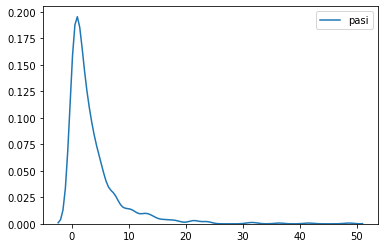

In [35]:
sns.kdeplot(df6.pasi)

In [36]:
cost, fitted_lambda = stats.boxcox(df6.pasi + 1e-10)
fitted_lambda

0.21162139496060905

In [70]:
df6['sexo'] = 1
df6[df6['sexo_paciente'] == 'm']['sexo'] = -1
df6["log_dpasi"] = np.log(df6["dpasi"]+1e-10)/25
df6["log_pasi"] = np.log(df6["pasi"]+1e-10)/25

p = 0.9
random.seed(1337)

ndata = len(df6)
# Randomly choose 0.8n indices between 1 and n
idx_train = np.random.choice(range(ndata),int(p*ndata),replace=False)
# The test set is comprised from all the indices that were
# not selected in the training set:
idx_test  = np.asarray(list(set(range(ndata)) - set(idx_train)))
train     = df6.iloc[idx_train] # the training data set
test      = df6.iloc[idx_test]  # the test data set
print(train.shape)
print(test.shape)  


ndata_0 = len(df6[df6['fracaso']==0])
ndata_1 = len(df6[df6['fracaso']==1])

# Randomly choose 0.8n indices between 1 and n
idx_train_0 = np.random.choice(range(ndata_0),int(p*ndata_0),replace=False)
idx_train_1 = np.random.choice(range(ndata_1),int(p*ndata_1),replace=False)
# The test set is comprised from all the indices that were
# not selected in the training set:
idx_test_0  = np.asarray(list(set(range(ndata_0)) - set(idx_train_0)))
idx_test_1  = np.asarray(list(set(range(ndata_1)) - set(idx_train_1)))

train_0     = df6[df6['fracaso']==0].iloc[idx_train_0] # the training data set
test_0      = df6[df6['fracaso']==0].iloc[idx_test_0]  # the test data set
train_1     = df6[df6['fracaso']==1].iloc[idx_train_1] # the training data set
test_1      = df6[df6['fracaso']==1].iloc[idx_test_1]  # the test data set

train = pd.concat([train_0, train_1], ignore_index=True)
test = pd.concat([test_0, test_1], ignore_index=True)
print(train.shape)
print(test.shape)  





(633, 69)
(71, 69)
(632, 69)
(72, 69)


In [38]:
varsX

['imc',
 'bsa',
 'dlqi',
 'depresion_total',
 'ansiedad_total',
 'trastorno_sexual_total',
 'psi_total',
 'medicamento_acido_folico__mometasona',
 'medicamento_acido_salicilico__mometasona',
 'medicamento_adalimumab',
 'medicamento_certolizumab',
 'medicamento_etanercept',
 'medicamento_golimumab',
 'medicamento_guselkumab',
 'medicamento_infliximab',
 'medicamento_ixekinumab',
 'medicamento_mometasona',
 'medicamento_secukinumab',
 'medicamento_ustekinumab',
 'edad',
 'eritema',
 'endurecimiento',
 'descamacion',
 'pga']

## Regresor a pasi

In [39]:


vX_X1 = [ 'pasi_1', 'edad' ,'sexo', 'imc_1', 'pga_1', 'dlqi_1',
         'medicamento_adalimumab',
         'medicamento_certolizumab',
         'medicamento_etanercept',
         'medicamento_golimumab',
         'medicamento_guselkumab',
         'medicamento_infliximab',
         'medicamento_ixekinumab',
         'medicamento_secukinumab',
         'medicamento_ustekinumab']

vY = 'pasi'
         
# 'dpasi', 'dpasi_mes', 'dpasi_porc_mes', 'dpasi_porc', 'fracaso', 'pasi'


reg = LazyRegressor(verbose=0,ignore_warnings=False, custom_metric=None)
models,predictions = reg.fit(train[vX_X1], test[vX_X1], train[vY], test[vY])
print(models)


 97%|█████████▋| 38/39 [00:03<00:00, 10.48it/s]

StackingRegressor model failed to execute
__init__() missing 1 required positional argument: 'estimators'


100%|██████████| 39/39 [00:04<00:00,  9.62it/s]

                               R-Squared   RMSE  Time Taken
Model                                                      
NuSVR                               0.14   4.53        0.07
MLPRegressor                        0.14   4.55        1.24
OrthogonalMatchingPursuitCV         0.13   4.57        0.03
OrthogonalMatchingPursuit           0.13   4.57        0.03
LarsCV                              0.13   4.58        0.05
LassoLarsCV                         0.13   4.58        0.03
ElasticNetCV                        0.12   4.60        0.11
Lasso                               0.12   4.60        0.03
LassoCV                             0.12   4.60        0.10
SVR                                 0.11   4.61        0.03
ElasticNet                          0.11   4.62        0.01
LassoLarsIC                         0.11   4.62        0.01
BayesianRidge                       0.11   4.63        0.01
RidgeCV                             0.11   4.63        0.03
SGDRegressor                        0.11

In [40]:

vX_X1 = [ 'pasi_1', 'edad' ,'sexo', 'imc_1', 'dlqi_1',
         'medicamento_adalimumab',
         'medicamento_certolizumab',
         'medicamento_etanercept',
         'medicamento_golimumab',
         'medicamento_guselkumab',
         'medicamento_infliximab',
         'medicamento_ixekinumab',
         'medicamento_secukinumab',
         'medicamento_ustekinumab']

vY = 'pasi'
         
# 'dpasi', 'dpasi_mes', 'dpasi_porc_mes', 'dpasi_porc', 'fracaso', 'pasi'


reg = LazyRegressor(verbose=0,ignore_warnings=False, custom_metric=None)
models,predictions = reg.fit(train[vX_X1], test[vX_X1], train[vY], test[vY])
print(models)

 97%|█████████▋| 38/39 [00:03<00:00, 10.96it/s]

StackingRegressor model failed to execute
__init__() missing 1 required positional argument: 'estimators'


100%|██████████| 39/39 [00:03<00:00, 10.21it/s]

                               R-Squared   RMSE  Time Taken
Model                                                      
NuSVR                               0.14   4.53        0.06
MLPRegressor                        0.14   4.55        1.01
OrthogonalMatchingPursuitCV         0.13   4.57        0.03
OrthogonalMatchingPursuit           0.13   4.57        0.02
LarsCV                              0.13   4.58        0.05
LassoLarsCV                         0.13   4.58        0.03
ElasticNetCV                        0.12   4.60        0.10
Lasso                               0.12   4.60        0.02
LassoCV                             0.12   4.60        0.13
SVR                                 0.11   4.61        0.03
ElasticNet                          0.11   4.62        0.01
LassoLarsIC                         0.11   4.62        0.01
BayesianRidge                       0.11   4.63        0.01
RidgeCV                             0.11   4.63        0.02
SGDRegressor                        0.11

## Regresor a dpasi

In [41]:

vX_X1 = [ 'pasi_1', 'edad' ,'sexo', 'imc_1', 'pga_1', 'dlqi_1',
         'medicamento_adalimumab',
         'medicamento_certolizumab',
         'medicamento_etanercept',
         'medicamento_golimumab',
         'medicamento_guselkumab',
         'medicamento_infliximab',
         'medicamento_ixekinumab',
         'medicamento_secukinumab',
         'medicamento_ustekinumab']

vY = 'dpasi'
         
# 'dpasi', 'dpasi_mes', 'dpasi_porc_mes', 'dpasi_porc', 'fracaso', 'pasi'


reg = LazyRegressor(verbose=0,ignore_warnings=False, custom_metric=None)
models,predictions = reg.fit(train[vX_X1], test[vX_X1], train[vY], test[vY])
print(models)

 97%|█████████▋| 38/39 [00:03<00:00,  9.50it/s]

StackingRegressor model failed to execute
__init__() missing 1 required positional argument: 'estimators'


100%|██████████| 39/39 [00:03<00:00, 10.05it/s]

                               R-Squared   RMSE  Time Taken
Model                                                      
MLPRegressor                        0.43   4.53        0.97
OrthogonalMatchingPursuitCV         0.42   4.57        0.03
OrthogonalMatchingPursuit           0.42   4.57        0.02
LarsCV                              0.41   4.61        0.05
LassoLarsCV                         0.41   4.61        0.03
LassoCV                             0.41   4.62        0.10
LassoLarsIC                         0.41   4.63        0.01
SGDRegressor                        0.40   4.64        0.02
Lars                                0.40   4.64        0.02
TransformedTargetRegressor          0.40   4.64        0.02
LinearRegression                    0.40   4.64        0.01
Ridge                               0.40   4.64        0.01
BayesianRidge                       0.40   4.64        0.01
RidgeCV                             0.40   4.64        0.02
ElasticNetCV                        0.40

In [42]:
vX_X1 = [ 'pasi_1', 'edad' ,'sexo', 'imc_1', 'dlqi_1', 'bsa_1', 'pga_1', 'trastorno_sexual_total_1', 
         'medicamento_adalimumab',
         'medicamento_certolizumab',
         'medicamento_etanercept',
         'medicamento_golimumab',
         'medicamento_guselkumab',
         'medicamento_infliximab',
         'medicamento_ixekinumab',
         'medicamento_secukinumab',
         'medicamento_ustekinumab']

vY = 'dpasi'

clf = LazyRegressor(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(train[vX_X1], test[vX_X1], train[vY], test[vY])
print(models)

100%|██████████| 39/39 [00:04<00:00,  8.55it/s]

                               R-Squared   RMSE  Time Taken
Model                                                      
GradientBoostingRegressor           0.44   4.52        0.13
OrthogonalMatchingPursuitCV         0.42   4.57        0.03
OrthogonalMatchingPursuit           0.42   4.57        0.03
LarsCV                              0.41   4.61        0.04
LassoLarsCV                         0.41   4.61        0.05
LassoCV                             0.41   4.62        0.11
MLPRegressor                        0.41   4.63        1.29
LassoLarsIC                         0.41   4.63        0.02
ExtraTreesRegressor                 0.40   4.64        0.24
TransformedTargetRegressor          0.40   4.64        0.01
LinearRegression                    0.40   4.64        0.02
Lars                                0.40   4.64        0.02
Ridge                               0.40   4.64        0.01
SGDRegressor                        0.40   4.64        0.02
BayesianRidge                       0.40

## Clasificador a fracaso

In [43]:

vX_X1 = [ 'pasi_1', 'edad' ,'sexo', 'imc_1', 'dlqi_1', 'bsa_1',
         'medicamento_adalimumab',
         'medicamento_certolizumab',
         'medicamento_etanercept',
         'medicamento_golimumab',
         'medicamento_guselkumab',
         'medicamento_infliximab',
         'medicamento_ixekinumab',
         'medicamento_secukinumab',
         'medicamento_ustekinumab']

vY = 'fracaso'

clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(train[vX_X1], test[vX_X1], train[vY], test[vY])
print(models)

100%|██████████| 30/30 [00:01<00:00, 16.47it/s]

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
AdaBoostClassifier                 0.74               0.64     0.64      0.72   
BernoulliNB                        0.72               0.63     0.63      0.70   
GaussianNB                         0.72               0.61     0.61      0.69   
LGBMClassifier                     0.70               0.60     0.60      0.68   
NearestCentroid                    0.63               0.60     0.60      0.64   
ExtraTreesClassifier               0.70               0.59     0.59      0.66   
PassiveAggressiveClassifier        0.65               0.58     0.58      0.64   
Perceptron                         0.60               0.58     0.58      0.61   
KNeighborsClassifier               0.68               0.58     0.58      0.65   
LinearDiscriminantAnalysis         0.72               0.57     0.57      0.65   
LabelPropagation            

In [192]:
vX_X1 = [ 'pasi_1', 'edad' ,'sexo', 'imc_1', 'dlqi_1', 'bsa_1', 'pga_1','trastorno_sexual_total_1',
         'medicamento_adalimumab',
         'medicamento_certolizumab',
         'medicamento_etanercept',
         'medicamento_golimumab',
         'medicamento_guselkumab',
         'medicamento_infliximab',
         'medicamento_ixekinumab',
         'medicamento_secukinumab',
         'medicamento_ustekinumab',
         'medicamento_mometasona'
        ]

vY = 'fracaso'

clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(train[vX_X1], test[vX_X1], train[vY], test[vY])
print(models)

100%|██████████| 30/30 [00:01<00:00, 15.10it/s]

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
KNeighborsClassifier               0.74               0.64     0.64      0.72   
BaggingClassifier                  0.67               0.62     0.62      0.67   
RandomForestClassifier             0.72               0.61     0.61      0.69   
DecisionTreeClassifier             0.64               0.60     0.60      0.65   
BernoulliNB                        0.71               0.60     0.60      0.68   
LGBMClassifier                     0.67               0.59     0.59      0.66   
XGBClassifier                      0.67               0.58     0.58      0.66   
LabelPropagation                   0.67               0.58     0.58      0.66   
LabelSpreading                     0.67               0.58     0.58      0.66   
SVC                                0.74               0.58     0.58      0.67   
ExtraTreesClassifier        

In [189]:
vX_X1 = [ 'pasi_1', 'edad' ,'sexo', 'imc_1', 'dlqi_1', 'bsa_1', 'pga_1',
         'medicamento_adalimumab',
         'medicamento_certolizumab',
         'medicamento_etanercept',
         'medicamento_golimumab',
         'medicamento_guselkumab',
         'medicamento_infliximab',
         'medicamento_ixekinumab',
         'medicamento_secukinumab',
         'medicamento_ustekinumab',
         'medicamento_mometasona'
        ]

vY = 'fracaso'


clf = DecisionTreeClassifier()
clf = clf.fit(train[vX_X1], train[vY])
y_obt = clf.predict(test[vX_X1])

tn, fp, fn, tp = confusion_matrix(test[vY], y_obt).ravel()
acc = accuracy_score(test[vY], y_obt)
print(confusion_matrix(test[vY], y_obt))
print(acc)

[[ 8 14]
 [11 39]]
0.6527777777777778


[[ 6 16]
 [ 5 45]]
0.7083333333333334
Th = 0.6122448979591836
[[11 11]
 [ 8 42]]


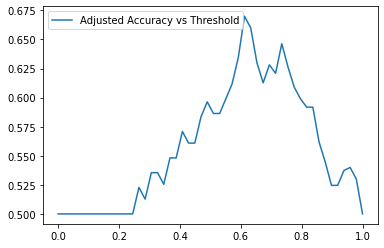

In [364]:
vX_X1 = [ 'pasi_1', 'edad' ,'sexo', 'imc_1', 'dlqi_1', 'bsa_1', 'pga_1',
         #'trastorno_sexual_total',
         #'depresion_total',
         #'ansiedad_total',
         'medicamento_adalimumab',
         'medicamento_certolizumab',
         'medicamento_etanercept',
         'medicamento_golimumab',
         'medicamento_guselkumab',
         'medicamento_infliximab',
         'medicamento_ixekinumab',
         'medicamento_secukinumab',
         'medicamento_ustekinumab',
         'medicamento_mometasona'
        ]

vY = 'fracaso'


clf = RandomForestClassifier(max_depth=10*len(vX_X1))
#clf = RandomForestClassifier()
clf = clf.fit(train[vX_X1], train[vY])
y_obt = clf.predict(test[vX_X1])
y_prob = clf.predict_proba(test[vX_X1])

tn, fp, fn, tp = confusion_matrix(test[vY], y_obt).ravel()
acc = accuracy_score(test[vY], y_obt)
print(confusion_matrix(test[vY], y_obt))
print(acc)

# sns.lineplot(x=test[vY], y=y_prob[:,1])
ths = np.linspace(0, 1, num=50)
Acc_s = 0*ths
k = 0
for th in ths:
    Acc_s[k] = balanced_accuracy_score(test[vY], y_prob[:,1]>th)
    # tn, fp, fn, tp = confusion_matrix(test[vY], y_prob[:,1]>th).ravel()
    #print('Th = ' + str(th))
    #print(confusion_matrix(test[vY], y_prob[:,1]>th))
    #print('Acc = ' + str(round(acc,3)))
    k += 1
sns.lineplot(x=ths, y=Acc_s, label="Adjusted Accuracy vs Threshold")
th = ths[Acc_s==max(Acc_s)]
acc = max(Acc_s)
print('Th = ' + str(th[0]))
print(confusion_matrix(test[vY], y_prob[:,1]>th[0]))

In [353]:

filename = ''
for c in vX_X1:
    filename = filename + '-' + c.replace('medicamento_','')
    
filename = 'Acc_' + str(round(acc,2)) + '-Th_' + str(round(acc,2)) + filename + '.joblib'

dump(clf, filename) 

['Acc_0.72-Th_0.72-pasi_1-edad-sexo-imc_1-dlqi_1-bsa_1-pga_1-adalimumab-certolizumab-etanercept-golimumab-guselkumab-infliximab-ixekinumab-secukinumab-ustekinumab-mometasona.joblib']

[[ 5 17]
 [ 7 43]]
0.6666666666666666
Th = 0.6122448979591836
[[11 11]
 [15 35]]


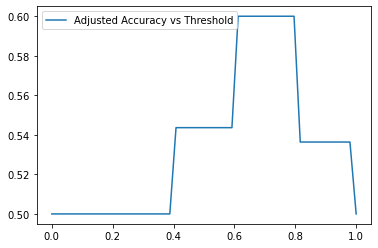

In [246]:
from sklearn.neighbors import KNeighborsClassifier

vX_X1 = [ 'pasi_1', 'edad' ,'sexo', 'imc_1', 'dlqi_1', 'bsa_1', 'pga_1',
         'trastorno_sexual_total',
         #'depresion_total',
         #'ansiedad_total',
         'medicamento_adalimumab',
         'medicamento_certolizumab',
         'medicamento_etanercept',
         'medicamento_golimumab',
         'medicamento_guselkumab',
         'medicamento_infliximab',
         'medicamento_ixekinumab',
         'medicamento_secukinumab',
         'medicamento_ustekinumab',
         'medicamento_mometasona'
        ]

vY = 'fracaso'


clf = KNeighborsClassifier()
clf = clf.fit(train[vX_X1], train[vY])
y_obt = clf.predict(test[vX_X1])
y_prob = clf.predict_proba(test[vX_X1])

tn, fp, fn, tp = confusion_matrix(test[vY], y_obt).ravel()
acc = accuracy_score(test[vY], y_obt)
print(confusion_matrix(test[vY], y_obt))
print(acc)

# sns.lineplot(x=test[vY], y=y_prob[:,1])
ths = np.linspace(0, 1, num=50)
Acc_s = 0*ths
k = 0
for th in ths:
    Acc_s[k] = balanced_accuracy_score(test[vY], y_prob[:,1]>th)
    # tn, fp, fn, tp = confusion_matrix(test[vY], y_prob[:,1]>th).ravel()
    #print('Th = ' + str(th))
    #print(confusion_matrix(test[vY], y_prob[:,1]>th))
    #print('Acc = ' + str(round(acc,3)))
    k += 1
sns.lineplot(x=ths, y=Acc_s, label="Adjusted Accuracy vs Threshold")
th = ths[Acc_s==max(Acc_s)]
acc = max(Acc_s)
print('Th = ' + str(th[0]))
print(confusion_matrix(test[vY], y_prob[:,1]>th[0]))

In [ ]:

filename = ''
for c in vX_X1:
    filename = filename + '-' + c.replace('medicamento_','')
    
filename = 'Acc_' + str(round(acc,2)) + '-Th_' + str(round(acc,2)) + filename + '.joblib'

dump(clf, filename) 

In [336]:
df6['pasi'].describe()

count   704.00
mean      3.66
std       5.03
min       0.00
25%       0.80
50%       2.05
75%       4.60
max      48.60
Name: pasi, dtype: float64

In [338]:
!conda list

# packages in environment at /opt/conda:
#
# Name                    Version                   Build  Channel
_libgcc_mutex             0.1                 conda_forge    conda-forge
_openmp_mutex             4.5                       0_gnu    conda-forge
absl-py                   0.9.0                    pypi_0    pypi
alembic                   1.4.2              pyh9f0ad1d_0    conda-forge
altair                    4.1.0                    pypi_0    pypi
astor                     0.8.1                    pypi_0    pypi
astunparse                1.6.3                    pypi_0    pypi
async_generator           1.10                       py_0    conda-forge
attrs                     19.3.0                     py_0    conda-forge
backcall                  0.1.0                      py_0    conda-forge
base58                    2.0.1                    pypi_0    pypi
beautifulsoup4            4.9.1            py37hc8dfbb8_0    conda-forge
blas                      2.14                   